# Part 2: Deep Reinforcement Learning

In this part of the assignment you will work on a more challenging control task in the [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). The state space is continuous and we will employ Deep Q-Learning (DQN) using a deep neural network to handle generalizing between states. 

**Learning objectives.** You will:
1. Implement the Deep Q-learning (DQN) algorithm with epsilon greedy action selection
2. Apply DQN to train an agent on a challenging control task with a large (continuous) state space
3. Evaluate the learning curve of average episodic return over training

While it is possible to complete this assignment using CPU compute, it may be slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

If you were able to run `pip install "gymnasium[all]"` in Part 1 then you may not need to install any additional dependencies to work with the Lunar Lander environment. However, if you were only able to install the base `gymnasium` then you may need to complete the additional installations of `swig` and `box2d` below. The first two commands use `pip` for the package manager, the third uses `conda` if you are using the Anaconda package manager.

In [1]:
pip install swig

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install box2d-py

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You can check that the installation was successful by running the following code. The code attempts to import the gymnasium module, create a [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/), and then execute random actions in the environment. 

The environment is set to `render_mode="human"`, meaning you should see a visualization of the environment with the agent taking random actions. Be aware that the visualization can be unstable on some platforms -- in particular, if your Python Kernel crashes after closing the visualization, that will not prevent you from completing the assignment (but is a good indication that you should save your learned Q tables/networks before rendering a visualization so that you don't lose any work).

In [2]:
pip install --upgrade numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import gymnasium as gym

# Initialise the environment
env = gym.make("LunarLander-v3", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset()
for _ in range(200):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

error: XDG_RUNTIME_DIR not set in the environment.


## Task 1

As we will be implementing DQN, your first task is to define a deep neural network architecture to use to estimate the Q function during training. You should familiarize yourself with the [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/) documentation to understand the state/observation space, action space, and reward function.

In [2]:
import torch

class NeuralNet(torch.nn.Module):
    """
    Implements a neural network representation of
    the q-function for use in DQN.
    """
    def __init__(self, state_val=8,action_val=4):
        super(NeuralNet, self).__init__()
        self.flatten = torch.nn.Flatten()
        # todo: finish constructor/initialization
        self.hidden=torch.nn.Linear(
            in_features=state_val,
            out_features=120
        )
        self.out=torch.nn.Linear(
            in_features=120,
            out_features=action_val
        )
        self.relu=torch.nn.ReLU()
        

    def forward(self, x):
        """
        Input should represent state/observation space encoding
        Output should be a q-function estimate for each possible
        discrete action.
        """
        a_h=self.hidden(x)
        z_h=torch.nn.functional.relu(a_h)
        out=self.out(z_h)
        return out

## Task 2

Your next task is to define the `LunarLanderAgent` which should also implement the deep Q-learning (DQN) algorithm. The structure of the class is left up to you: While you are welcome to adopt a similar structure of `__init__`, `action_select`, and `update` as in Part 1, you are also free to change the structure as you see fit. 

The implementation will be more challenging than in the Part 1 tabular case. You may wish to review 11/25's lecture in particular for a discussion of the implementation. A few tips and reminders:
1. You should use a main Q-network, the weights of which you will regular update, and a frozen target Q-network used to predict the future predictive target, the weights of which you will periodically copy from the main Q-network. You should copy these weights only everal several thousand steps in the environment for stability. Both should share the same architecture you defined above and should be saved as instance variables of your agent, along with a PyTorch loss MSE loss function and optimizer.
2. You should use an experience replay buffer and employ batched updates to the weights of your Q-network. The easiest data structure to use for the experience replay buffer is probably the [Python collections deque](https://docs.python.org/3/library/collections.html#collections.deque). You probably want an experience replay buffer that is at least as large as 100,000 experiences, if not more.
3. You will likely need a lower learning rate such as `0.001` or `0.0005`. Also, you will want a good amount of exploration early on. If using `epsilon` decay, you should decay only very slowly, as you should expect to need thousands of episodes to learn a good policy.
4. While you are not required to use GPU training for Q-network operations, it will substantially accelerate training, and you are encouraged to do so. Make sure not to store all of the experiences in your entire experience replay buffer on the GPU. Instead, store those on CPU memory and only move batches on GPU before training. Otherwise you are likely to run out of memory during training.

In [3]:
from collections import deque
import random
import numpy as np
class LunarLanderAgent:
    def __init__(self, env, lr=0.0005, discount=0.99, epsilon_init=1.0, epsilon_final=0.05, epsilon_decay=0.99,
    batch_size=32, buffer_size=100000, n_clone=4096, warmup_time=2048, update_freq=4):
        self.env=env
        self.lr=lr
        self.discount=discount
        self.epsilon=epsilon_init
        self.epsilon_final=epsilon_final
        self.epsilon_decay=epsilon_decay
        self.batch_size=batch_size
        self.buffer_size=buffer_size
        self.replay_buffer = deque(maxlen=self.buffer_size)
        self.n_clone=n_clone
        self.warmup_time=warmup_time
        self.update_freq=update_freq
        
        self.gpu=torch.device("cuda")
        self.q=NeuralNet().to(self.gpu)
        self.q_target=NeuralNet().to(self.gpu)
        self.q_target.eval()
        self.loss=torch.nn.MSELoss()
        self.optimizer=torch.optim.Adam(self.q.parameters(),lr=self.lr)
        self.counter=0
    def update_target(self):
        self.q_target.load_state_dict(self.q.state_dict())
    def action_select(self,state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.gpu)
        if np.random.random()<self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                out=self.q(state_tensor)
                return torch.argmax(out).item()
    def get_batch(self):
        batch = random.sample(self.replay_buffer, self.batch_size)
        state, action, reward, s_next, terminated = zip(*batch)
        states_tensor = torch.tensor(state, dtype=torch.float32).to(self.gpu)
        actions_tensor = torch.tensor(action, dtype=torch.long).to(self.gpu)
        rewards_tensor = torch.tensor(reward, dtype=torch.float32).to(self.gpu)
        next_states_tensor = torch.tensor(s_next, dtype=torch.float32).to(self.gpu)
        terminated_tensor = torch.tensor(terminated, dtype=torch.float32).to(self.gpu)
        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, terminated_tensor
    def update(self, s_old, a, r, s_new, terminated):
        self.replay_buffer.append((s_old, a, r, s_new, terminated))
        if self.counter%self.update_freq==0 and self.counter>self.warmup_time:
            state, action, reward, s_next, terminated = self.get_batch()
            q_val=self.q(state)
            action_idx=action.unsqueeze(-1)
            predicted=q_val.gather(dim=1, index=action_idx)
            predicted=predicted.squeeze()
            with torch.no_grad():
                targets=reward
                next_q_val=self.q_target(s_next)
                discount=self.discount*(next_q_val.max(dim=1)[0])*(1-terminated)
                targets+=discount
            loss=self.loss(predicted,targets)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if self.counter%self.n_clone==0:
            self.update_target()

        

## Task 3

Train your DQN agent on the Lunar Lander environment. You should be able to learn a policy that achieves an average/expected episode return (cumulative reward) of approximately 200 or more -- **we will consider the training a success if the average/expected episode return converges to greater than 150**. To accomplish this you may need to experiment with several of the key hyperparameters for the learning agent. Note that the learning will likely be much more challenging and variable than in the Part 1 warmup task.

While you are not required, you are encouraged to print periodic evaluation information during training (for example, every 100 or so episodes you may wish to printout the average return of the last 100 episodes) in order to track progress.

Training will take quite some time on this environment: You should expect to need between **1 and 10 thousand episodes** of experience (You should use a small number between 100 and 1 thousand while prototyping your implementation, then several thousand for your final training). Even with GPU acceleration you should expect this to take **several minutes or as much as an hour** (for your final run over several thousand episodes). Partially for this reason, you are strongly encourage to **save your Q-network model parameters** after a substantial and long training run, to ensure you do not lose them. See the [PyTorch documentation on loading and saving model parameters](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

It is relatively common/likely on this lunar lander environment to get stuck in a local optimum where the agent learns to "hover" but not land. Landing correctly is difficult and crashing incurs a large negative reward, so sometimes the agent gets "stuck" in a policy of hovering in place without attempt to land. This results in an average return of around 0. If your agent is getting stuck like this, one recommendation is to modify the reward function by adding a per-timestep reward penalty during learning. You can do this very simply in the training loop by just reducing the reward as in `r = r - timestep_penalty` before passing the experience to your agent. A value for `timestep_penalty` between 0.1 and 0.5 may help to incentivize the agent not to "hover" but to actually attempt and learn how to land. 

In [7]:
# Initialise the environment
import gymnasium as gym

# todo: adjust n_episodes as needed for training
# default value of 100 for prototyping, will likely
# want more episodes for training
n_episodes = 5000

env = gym.make("LunarLander-v3")

# wrapper saves episode information necessary for later evaluation in task 4
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length = n_episodes)
agent=LunarLanderAgent(env)
return_total=0
win_check=200
win_counter=0
win_amount=1
decay=False
for episode in range(n_episodes):
    state, info=env.reset()
    episode_over=False
    eps_return=0
    while not episode_over:
        a=agent.action_select(state)
        s_new, r, terminated, truncated, info =env.step(a)
        eps_return+=r
        agent.update(state, a, r, s_new, terminated)
        episode_over= terminated or truncated
        state=s_new
        agent.counter+=1
    return_total+=eps_return
    if decay:
        agent.epsilon=max(agent.epsilon_final,agent.epsilon_decay*agent.epsilon)
        decay=False
    else:
        decay=True
    if eps_return>=win_check:
        win_counter+=1
    if win_counter==win_amount:
        print(f"Winner Winner Chicken Dinner! You have {win_counter} lands!")
        win_amount*=5
    if episode%100==0:
        print(f"episode num:{episode} avg return: {(return_total/100) } epsilon: {agent.epsilon}")
        return_total=0
env.close()    

episode num:0 avg return: -3.338629170156846 epsilon: 1.0
episode num:100 avg return: -196.35711088894286 epsilon: 0.6050060671375365
episode num:200 avg return: -159.98272918078968 epsilon: 0.36603234127322926
episode num:300 avg return: -180.5313476056455 epsilon: 0.22145178723886094
episode num:400 avg return: -129.5701215564532 epsilon: 0.13397967485796175
episode num:500 avg return: -94.8995208168113 epsilon: 0.08105851616218133
Winner Winner Chicken Dinner! You have 1 lands!
episode num:600 avg return: -25.062460766664334 epsilon: 0.05
episode num:700 avg return: -25.985200983379094 epsilon: 0.05
episode num:800 avg return: -49.301270479804764 epsilon: 0.05
episode num:900 avg return: -45.84956301318191 epsilon: 0.05
Winner Winner Chicken Dinner! You have 5 lands!
episode num:1000 avg return: -44.7392323908618 epsilon: 0.05
episode num:1100 avg return: 8.040874496906474 epsilon: 0.05
episode num:1200 avg return: 28.0033616759609 epsilon: 0.05
Winner Winner Chicken Dinner! You hav

## Task 4

After training, you can use the `visualize_learning_curves` function below to create two plots: One of the moving average episode return over the course of training and another of the moving average episode length over the course of training. A `smoothing` parameter to the function determines how many episodes to average over. That is, the default of `smoothing=10` means that each point in the resulting figure is the average of ten episodes. This has the visual effect of *smoothing* out the appearance of the plot, which can make the overall trend easier to visualize even if individual episodes vary significantly.

Create visualizations of your learning curves. You should see improving performance on average episode return converging toward approximately 150 or above. The learning may be more variable than in Part 1, so you may wish to increase the `smoothing` parameter to `50` or even `100` to make it easier to visualize the average trend.

In [10]:
# Run, but you do not need to modify this code

import numpy as np
from matplotlib import pyplot as plt
def visualize_learning_curves(env, smoothing=50):
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(np.convolve(env.return_queue, np.ones(smoothing), 'valid') / smoothing)
    axs[0].set_title("Episode Returns", fontsize=20)
    axs[0].set_xlabel("Episode", fontsize=20)
    axs[0].set_ylabel("Return", fontsize=20)

    axs[1].plot(np.convolve(env.length_queue, np.ones(smoothing), 'valid') / smoothing)
    axs[1].set_title("Episode Lengths", fontsize=20)
    axs[1].set_xlabel("Episode", fontsize=20)
    axs[1].set_ylabel("Length", fontsize=20)

    plt.tight_layout()
    plt.show()

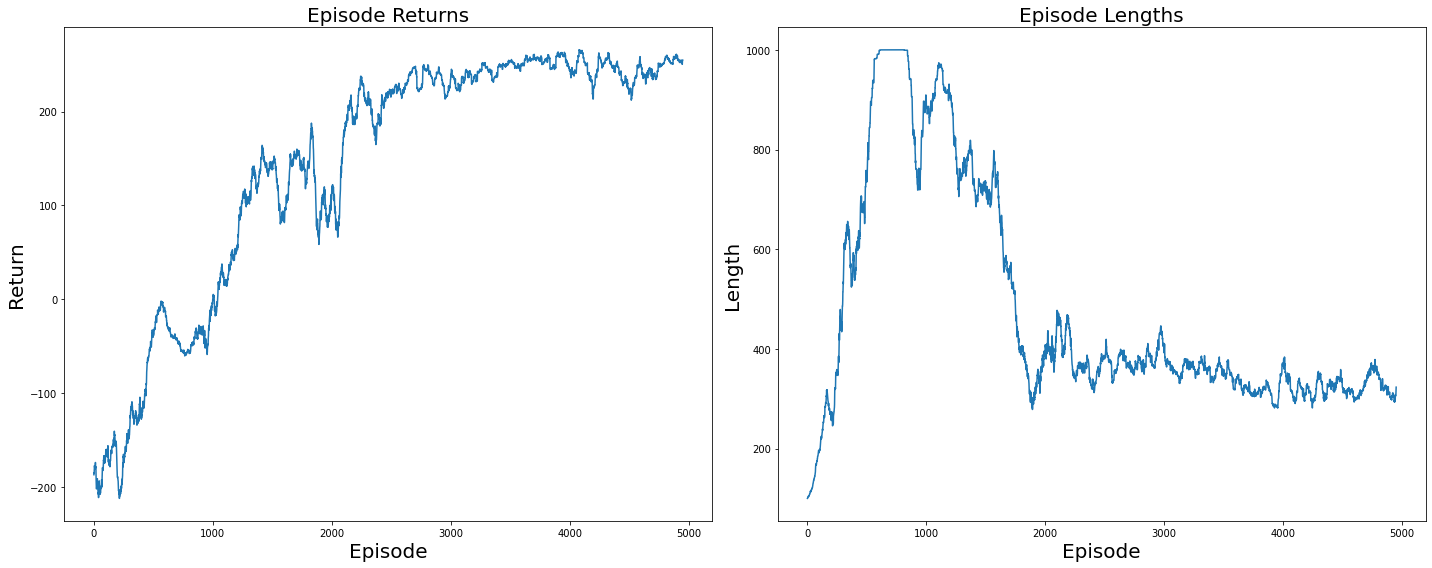

In [11]:
# todo: visualize learning curves
visualize_learning_curves(env)

## Optional

The above evaluation of the learning curve was purely quantiative. While you are not required, you are invited and encouraged to qualitatively evaluate your learned policy/agent visually below. To do so, render the environment in `"human"` mode as shown below. This should render the visualization of the environment. Write a standard environment loop over several episodes (but far fewer than used for training, perhaps just 5 or so), and use the trained agent for action selection. For this evaluation purpose, you are welcome to set `epsilon` to a lower value or even 0, and you do not need to perform learning updates.

Again, be aware that the visualization can be unstable on some platforms -- in particular, if your Python Kernel crashes after closing the visualization, that will not prevent you from completing the assignment (but is a good indication that you should save your learned Q tables/networks before rendering a visualization so that you don't lose any work).

In [ ]:
# Initialise the environment
env = gym.make("LunarLander-v3", render_mode="human")

# optional todo: environment loop to visualize learned policy